In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
import netCDF4
from IPython.display import clear_output
import torch
import torch.nn as nn
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def print_peak_gpu_memory():
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
    print(f"Peak GPU memory used: {peak_memory:.2f} MB.")
    torch.cuda.reset_peak_memory_stats()  # Reset after printing


def print_gpu_utilization():
    nvmlInit()  # Initialize NVML
    handle = nvmlDeviceGetHandleByIndex(0)  # Assuming we're using GPU 0
    info = nvmlDeviceGetMemoryInfo(handle)  # Get memory info
    print(f"GPU memory occupied: {info.used // 1024**2} MB.")

def visualize(Z_surf,time,H_ice):
        clear_output(wait=True)  # Clear the previous output in the notebook
        plt.figure(2, figsize=(11, 4), dpi=200)
        # First subplot: Ice surface
        plt.subplot(1, 2, 1)
        plt.imshow(Z_surf.cpu().numpy(), cmap='terrain', origin='lower')
        plt.colorbar(label='Elevation (m)')
        plt.title('Ice Surface at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Second subplot: Ice thickness
        plt.subplot(1, 2, 2)
        plt.imshow(np.where(H_ice.cpu().numpy() > 0, H_ice.cpu().numpy(), np.nan), cmap='jet', origin='lower')
        plt.colorbar(label='Ice Thickness (m)')
        plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Show the plot
        plt.show()

# Function to create and plot a 2D smooth random ELA field
def generate_and_plot_ELA_field(Z_topo, Z_ELA, ELA_range=200, octaves=4, seed=42, device='cpu'):
    # Get the dimensions of Z_topo
    height, width = Z_topo.shape

    # Initialize Perlin noise
    noise = PerlinNoise(octaves=octaves, seed=seed)

    # Generate a 2D noise field
    noise_field = torch.tensor(
        [[noise([i / height, j / width]) for j in range(width)] for i in range(height)],
        dtype=torch.float32, device=device
    )

    # Normalize the noise field to be between -1 and 1
    min_noise = torch.min(noise_field)
    max_noise = torch.max(noise_field)
    normalized_noise = 2 * (noise_field - min_noise) / (max_noise - min_noise) - 1

    # Scale the noise to the range [Z_ELA - ELA_range, Z_ELA + ELA_range]
    ELA_field = Z_ELA + ELA_range * normalized_noise

    # # Plot the ELA field
    # plt.figure(figsize=(10, 8))
    # plt.imshow(ELA_field.cpu(), cmap='viridis', origin='lower')
    # plt.colorbar(label='ELA (m)')
    # plt.title('2D Smooth Random ELA Field')
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    # plt.show()

    return ELA_field

# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n db/dELA:",torch.mean(grad))
    return grad
def print_hook_h(grad):
    print("\n dH/db:",torch.mean(grad))
    return grad
def sqrt_hook(grad):
    if torch.abs(torch.mean(grad))>1:
        print(grad**0.5)
        return grad**0.5
def reduce_hook(grad):
    return grad*0.9

In [4]:
# Physical parameters

nc_file = netCDF4.Dataset('../data/geology_200m.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)
ice_mask = torch.tensor(nc_file.variables['icemask'][:], device=device)
ttot = 220  # Time limit (yr)
grad_b = 0.008  # Mass balance gradient
b_max = 2.3  # Maximum precip (m/yr)
# ELA = 3000  # Elevation of equilibrium line altitude (m)
# Generate and plot the ELA field
Z_ELA =2700 #generate_and_plot_ELA_field(Z_topo, ELA,device=device)
rho, g, fd = 910.0, 9.81, 1e-18
thk_1880 = torch.tensor(nc_file.variables['thk_1880'][:], device=device)


In [5]:
def solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA, rho=rho, g=g, fd=fd,dx=200,dy=200,dtmax = 1,device=device):
    """
    Solve the glacier dynamics using a diffusion-based solver with PyTorch.
    """
    # Physical parameters (unchanged)


    epsilon= 1.e-40

    # Initialize ice thickness and surface
    H_ice = torch.zeros(Z_topo.shape, device=device, dtype=torch.float32)
    Z_surf = Z_topo + H_ice
    # Initialize time and iteration counter
    time = torch.tensor(0.0, device=device, dtype=torch.float32)
    dt = torch.tensor(dtmax, device=device, dtype=torch.float32)
    it = 0

    while time < ttot:
        time += dt
        it += 1

        # Compute H_avg
        H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

        # Compute Snorm
        Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / dx
        Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / dy
        Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
        Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
        Snorm = torch.sqrt(Sx**2 + Sy**2 + epsilon)  # Add a small value to avoid division by zero

        # Compute diffusivity
        D = fd * (rho * g)**3.0 * H_avg**5 * Snorm**2+ epsilon

        # Compute adaptive time step
        dt = min(min(dx, dy)**2 / (4.1 * torch.max(D).item()), dtmax)

        # Compute fluxes
        qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / dx
        qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / dy

        # Compute thickness change rate
        dHdt = -(torch.diff(qx, dim=1) / dx + torch.diff(qy, dim=0) / dy)

        # Update ice thickness
        H_ice[1:-1, 1:-1] += dt * dHdt

        # Compute surface mass balance (SMB)
        b = torch.minimum(grad_b * (Z_surf - Z_ELA), torch.tensor(b_max, device=device))*ice_mask
        # b.retain_grad() 
        # b.register_hook(reduce_hook)

        H_ice[1:-1, 1:-1] += dt * b[1:-1, 1:-1]

        # Ensure ice thickness remains positive
        H_ice = torch.maximum(H_ice, torch.tensor(0.0, device=device))
        # Update surface topography
        Z_surf = Z_topo + H_ice

        # Visualization at specified intervals
        # if it % 50 == 0:
        #     visualize(Z_surf,time,H_ice,Lx,Ly)
    return H_ice, it


In [18]:
# Assume Z_topo is a 2D tensor [ny, nx]
ny, nx = Z_topo.shape

# Create a 1D linear gradient from west (2200) to east (2700)
ela_west = 3200
ela_east = 2500
ela_gradient_1d = torch.linspace(ela_west, ela_east, steps=nx, device=device)

# Expand this gradient to a full 2D field
Z_ELA = ela_gradient_1d.unsqueeze(0).repeat(ny, 1)  # Shape: [ny, nx]

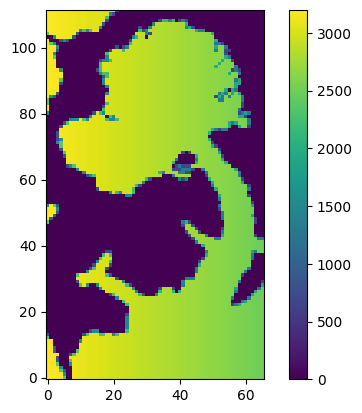

In [19]:
# true ELA 
plt.figure()
plt.imshow((Z_ELA*ice_mask).cpu().numpy())
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [20]:
h,it=solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA)
print(it)
# torch.save(h,'Obs_2D.pt')

14313


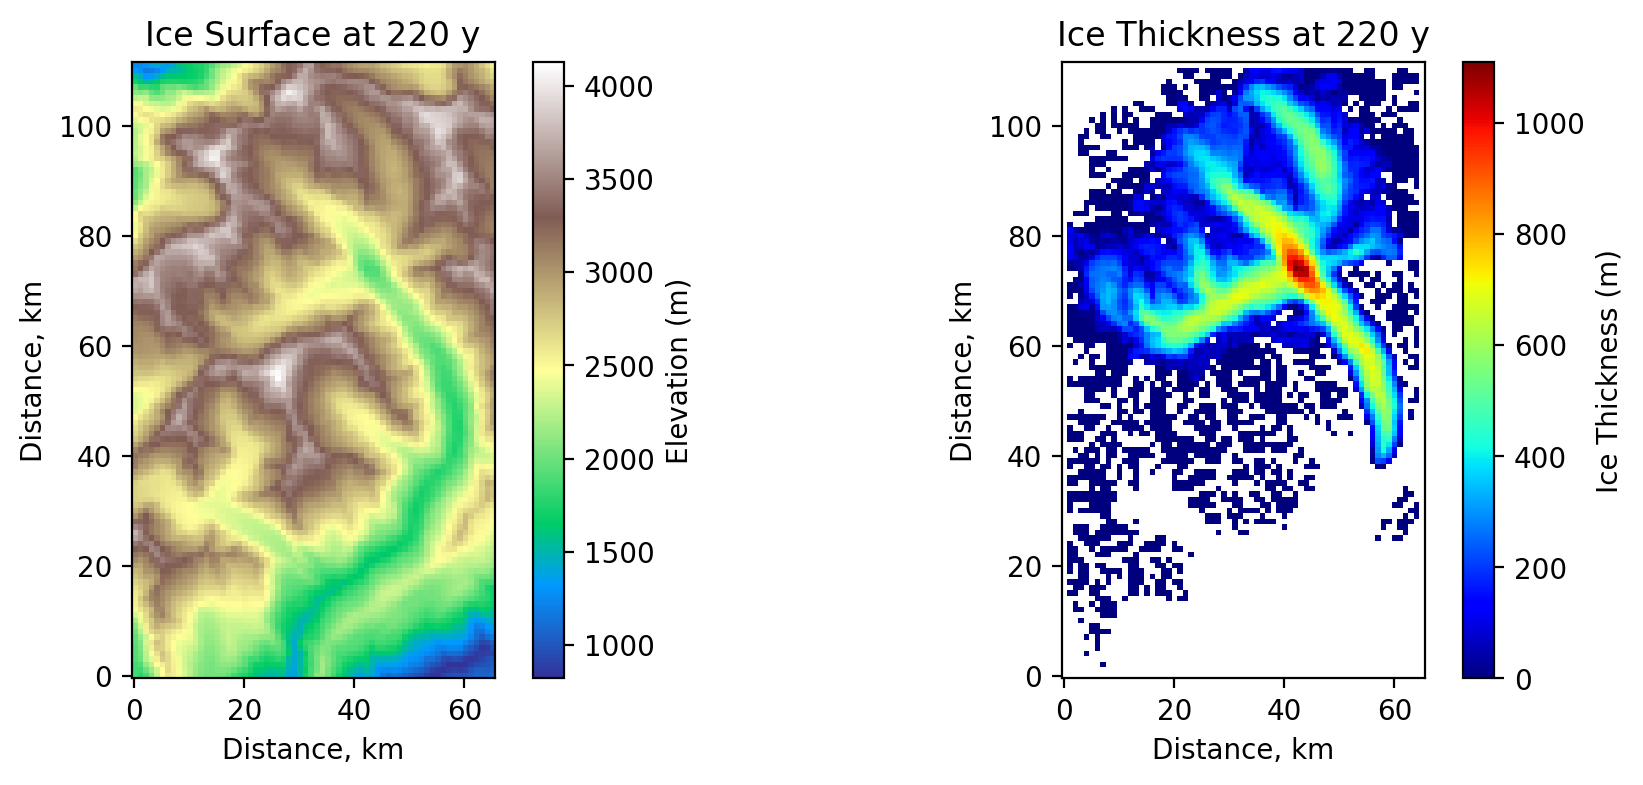

In [21]:
visualize(Z_topo,ttot,h.detach())

In [22]:
print_gpu_utilization()
print_peak_gpu_memory()

GPU memory occupied: 390 MB.
Peak GPU memory used: 0.89 MB.


### Inversion with ADAM

In [6]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()
# Initial guesses for inversion problem
Z_ELA = torch.full(Z_topo.shape,2500., requires_grad=True, device=device)


# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt', weights_only=True).to(device) # Ensure it's on the right device

# Define initial and final learning rates
initial_lr = 5  
final_lr = 3
reg_lambda=0.000005
n_iterations = 10

# Optimizer setup
optimizer = torch.optim.Adam([Z_ELA], lr=initial_lr)

# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history=[]

for i in range(n_iterations):
    # Update the learning rate
    lr = initial_lr - (i / (n_iterations - 1)) * (initial_lr - final_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.zero_grad()  # Zero gradients
    
    # Perform forward simulation
    H_simulated, it= solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA)

    print(it)
    # Compute data fidelity term
    data_fidelity = torch.mean((H_simulated - observed_thk) ** 2)

    # # Compute smoothness regularization (differences in x and y directions)
    # smoothness_x = torch.sum((Z_ELA[:, 1:] - Z_ELA[:, :-1]) ** 2)
    # smoothness_y = torch.sum((Z_ELA[1:, :] - Z_ELA[:-1, :]) ** 2)
    # smoothness_reg = smoothness_x + smoothness_y

    # Total loss
    loss = data_fidelity # + reg_lambda * smoothness_reg
     
    # Backpropagate loss and update parameters
    loss.backward()

    # Store the gradients and ELA evolution
    total_gradients_history.append(torch.max(Z_ELA.grad).item())

    optimizer.step()

    # Store loss components for plotting later
    total_loss_history.append(loss.item())
    data_fidelity_history.append(data_fidelity.item())
    # regularization_history.append((reg_lambda * smoothness_reg).item())
    # Print loss, gradients and current parameters every 50 iterations 
    if (i + 1) % 2 == 0:
        print(f"\nIteration {i+1}/{n_iterations}, Loss: {loss:.3f}, ELA: {torch.mean(Z_ELA).item()}; {torch.min(Z_ELA).item()}")
        print(f"Gradient of ELA : {torch.max(Z_ELA.grad).item()}")

        print_gpu_utilization()  # Print memory after the loop
        print_peak_gpu_memory()  # Print the peak memory   

/tmp/ipykernel_62179/3943781154.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.minimum(grad_b * (Z_surf - Z_ELA), torch.tensor(b_max, device=device))*ice_mask


24375
6093

Iteration 2/10, Loss: 51585.645, ELA: 2500.892333984375; 2491.798583984375
Gradient of ELA : 513.2667846679688
GPU memory occupied: 9316 MB.
Peak GPU memory used: 8831.27 MB.
6070
6057

Iteration 4/10, Loss: 51080.801, ELA: 2501.397705078125; 2487.600341796875
Gradient of ELA : 3741.369140625
GPU memory occupied: 9316 MB.
Peak GPU memory used: 2199.37 MB.
6042
6027

Iteration 6/10, Loss: 50594.969, ELA: 2501.8056640625; 2480.93603515625
Gradient of ELA : 0.6004021763801575
GPU memory occupied: 9316 MB.
Peak GPU memory used: 2189.22 MB.
22980
7438

Iteration 8/10, Loss: 31399.666, ELA: 2501.991943359375; 2475.277587890625
Gradient of ELA : 0.30022385716438293
GPU memory occupied: 9316 MB.
Peak GPU memory used: 8325.94 MB.
7278
7088

Iteration 10/10, Loss: 33158.570, ELA: 2502.118408203125; 2471.380126953125
Gradient of ELA : 0.09198585897684097
GPU memory occupied: 9316 MB.
Peak GPU memory used: 2637.03 MB.


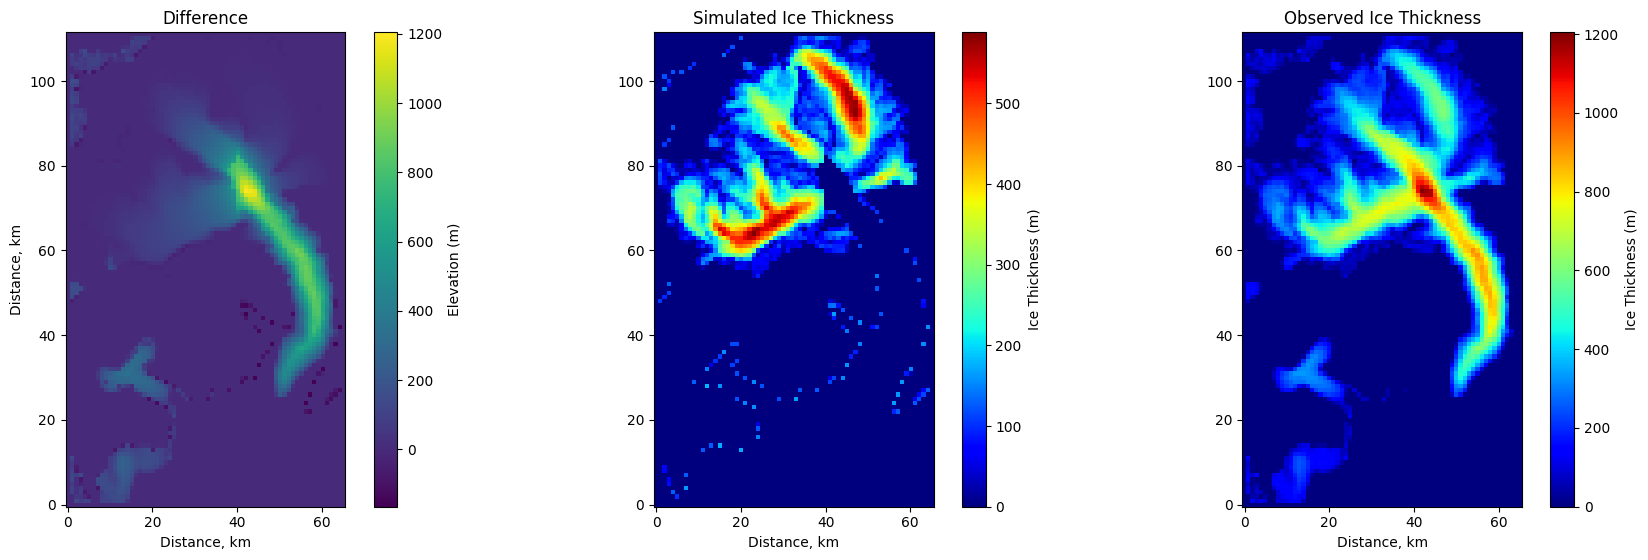

In [7]:
# Convert tensors to NumPy arrays for plotting
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(observed_thk_np-H_ice_np, origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Elevation (m)')
ax[0].set_title('Difference')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow( H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Ice Thickness (m)')
ax[1].set_title('Simulated Ice Thickness')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(observed_thk_np, cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='Ice Thickness (m)')
ax[2].set_title('Observed Ice Thickness')
ax[2].set_xlabel('Distance, km')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


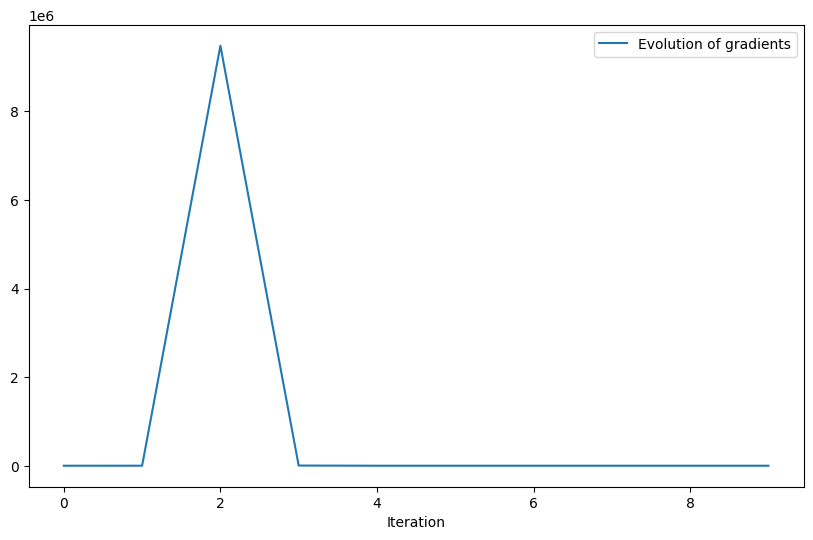

In [8]:
plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
plt.plot(total_gradients_history, label='Evolution of gradients')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [9]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history, data_fidelity_history, regularization_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Total Loss', color='b', linewidth=2)
    plt.plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    plt.plot(regularization_history, label='Regularization (Smoothness)', color='r', linestyle='-.', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

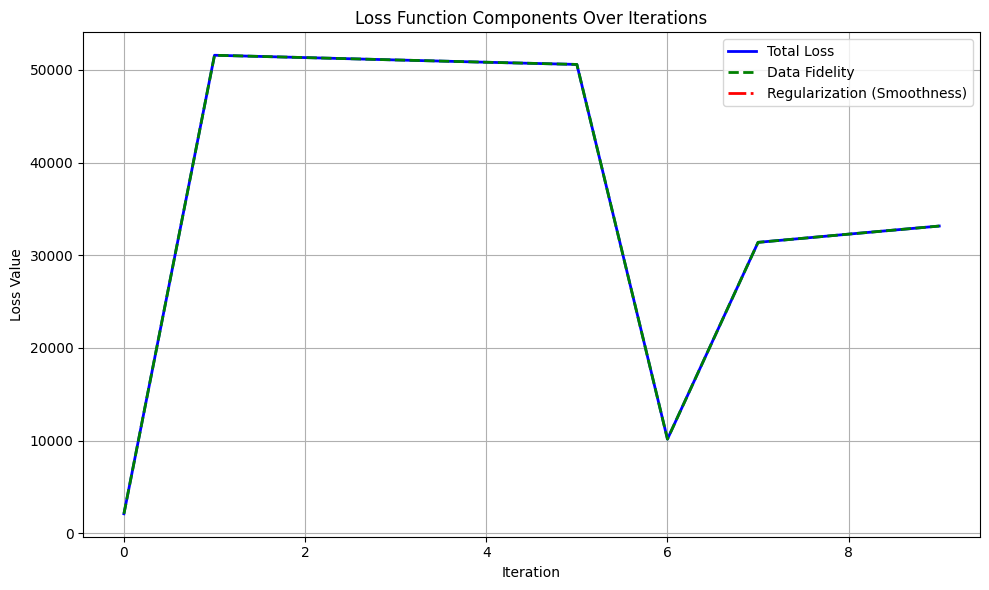

In [10]:
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history)

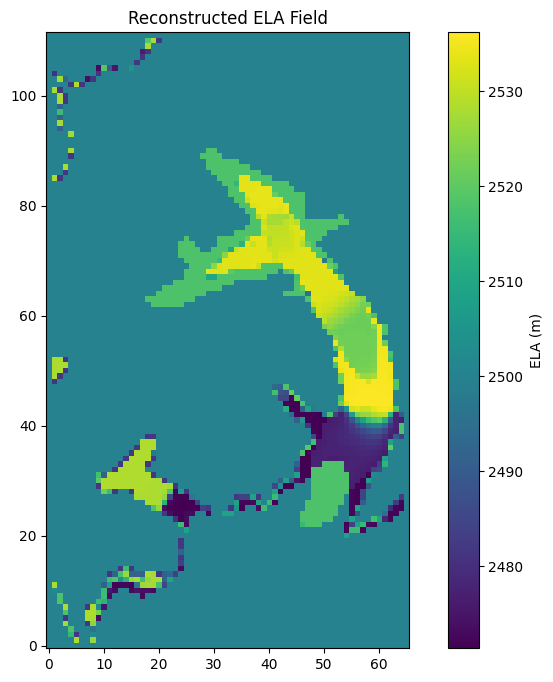

In [11]:
# Plot the ELA field
plt.figure(figsize=(10, 8))
# Detach the tensor from the computation graph and move it to the CPU before converting to a NumPy array
plt.imshow(Z_ELA.detach().cpu().numpy(), cmap='viridis', origin='lower')
plt.colorbar(label='ELA (m)')
plt.title('Reconstructed ELA Field')
plt.savefig('inverted_ELA')
plt.show()


In [ ]:
# Save ELA
torch.save(Z_ELA,"inverted_ELA.pt")